### Import Library

In [1]:
# Base Library
import pandas as pd
import numpy as np

# Library untuk Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

# Library untuk Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Library untuk Modeling dengan XGBoost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
import optuna

# Library untuk Evaluasi Model
from sklearn.metrics import mean_absolute_percentage_error, r2_score, root_mean_squared_error

e:\Program\Anaconda\envs\skripsi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Business Understanding
---

- AAAA
- AAAA

### Data Understanding

In [2]:
# Baca Data
df = pd.read_csv("hasil_scraping_rumah123.csv", engine='pyarrow', sep=';')
df = df.drop(columns=['IMB', 'Lainnya', 'Garasi'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URL                   4991 non-null   object
 1   Harga                 4991 non-null   object
 2   Lokasi                4991 non-null   object
 3   Kamar Tidur           4991 non-null   int64 
 4   Kamar Mandi           4991 non-null   int64 
 5   Luas Tanah            4991 non-null   object
 6   Luas Bangunan         4991 non-null   object
 7   Sertifikat            4991 non-null   object
 8   Daya Listrik          4991 non-null   object
 9   Jumlah Lantai         4991 non-null   int64 
 10  Kondisi Properti      4991 non-null   object
 11  Carport               4991 non-null   int64 
 12  Kamar Tidur Pembantu  4991 non-null   int64 
 13  Kamar Mandi Pembantu  4991 non-null   int64 
dtypes: int64(6), object(8)
memory usage: 546.0+ KB


In [3]:
# Lihat 5 baris data pertama
df.head()

,URL,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


In [4]:
# Fungsi untuk mengkonversi harga dengan koma sebagai desimal
def convert_price(price):
    # Hapus 'Rp' dan spasi
    price = price.replace('Rp', '').strip()
    
    # Pisahkan angka dan satuan
    if 'Juta' in price:
        value = price.replace(' Juta', '').replace(',', '.')  # Ubah koma jadi titik
        multiplier = 1e6  # 1 Juta = 1.000.000
    elif 'Miliar' in price:
        value = price.replace(' Miliar', '').replace(',', '.')  # Ubah koma jadi titik
        multiplier = 1e9  # 1 Miliar = 1.000.000.000
    else:
        return None  # Jika format tidak sesuai
    
    # Konversi ke float dengan titik desimal, lalu ke integer
    value = float(value)  
    return int(value * multiplier)

# Menkonversi kolom 'Harga'
df['Harga'] = df['Harga'].apply(convert_price)

# Lihat 5 baris pertama setelah kolom 'Harga' dikonversi
df.head()

,URL,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


In [5]:
# # Cek lokasi
# # Cek apakah kolom "Lokasi" ada di dataset
# if "Lokasi" in df.columns:
#     # Hitung jumlah kemunculan tiap lokasi
#     lokasi_counts = df["Lokasi"].value_counts()
    
#     # Simpan hasilnya ke file teks
#     file_path = "lokasi_counts.txt"
#     lokasi_counts.to_csv(file_path, sep="\t", header=True)

#     print(f"Hasil disimpan di: {file_path}")
# else:
#     print("Kolom 'Lokasi' tidak ditemukan dalam dataset.")

In [6]:
# Mapping lokasi
# Daftar kecamatan di Kabupaten Tangerang
desa_kabupaten = {
    "BSD Eminent": "Pagedangan",
    "BSD Green Wich": "Pagedangan",
    "BSD Avani": "Pagedangan",
    "BSD Vanya Park": "Pagedangan",
    "BSD Foresta": "Pagedangan",
    "BSD The Green": "Pagedangan",
    "BSD Kencana Loka": "Pagedangan",
    "BSD Taman Giri Loka": "Pagedangan",
    "BSD Telaga Golf": "Pagedangan",
    "BSD Neo Catalonia": "Pagedangan",
    "BSD Provance Parkland": "Pagedangan",
    "BSD Alegria": "Pagedangan",
    "Cikupa": "Cikupa",
    "Cikupa Citra Raya": "Cikupa",
    "Cisauk" : "Cisauk",
    "Suvarna Sutera": "Cikupa",
    "Panongan": "Panongan",
    "Curug": "Curug",
    "Legok": "Legok",
    "Pasar Kemis": "Pasar Kemis",
    "Sepatan": "Sepatan",
    "Bitung": "Curug",
    "Tigaraksa": "Tigaraksa",
    "Balaraja": "Balaraja",
    "Jayanti": "Jayanti",
    "Kosambi": "Kosambi",
    "Teluk Naga": "Teluk Naga",
    "Mauk": "Mauk",
    "Kresek": "Kresek",
    "Solear": "Solear",
    "Sindang Jaya": "Sindang Jaya",
    "Rajeg": "Rajeg",
    "Kadu": "Kadu",
    "Jatake": "Jatiuwung",
    "Bojong Nangka": "Kelapa Dua",
    "Suradita": "Cisauk",
    "Cukang Galih": "Curug",
    "Gading Serpong": "Kelapa Dua",
    "Gading Serpong Pondok Hijau Golf": "Kelapa Dua",
    "Gading Serpong The Spring": "Kelapa Dua",
    "Gading Serpong Scientia Garden": "Kelapa Dua",
    "Gading Serpong Samara Village": "Kelapa Dua",
    "Gading Serpong IL Lago": "Kelapa Dua",
    "Gading Serpong Elista Village": "Kelapa Dua",
    "Gading Serpong Serenade Lake": "Kelapa Dua",
    "Gading Serpong Cluster Bohemia": "Kelapa Dua",
    "Gading Serpong Omaha Village": "Kelapa Dua",
    "Gading Serpong La Bella Village": "Kelapa Dua",
    "Gading Serpong Virginia Village": "Kelapa Dua",
    "Gading Serpong Cluster Oleaster": "Kelapa Dua",
    "Gading Serpong Cluster Michelia": "Kelapa Dua",
    "Gading Serpong Karelia Village": "Kelapa Dua",
    "Gading Serpong Andalucia": "Kelapa Dua",
    "Gading Serpong Cluster IL Rosa": "Kelapa Dua",
    "Pasar Kemis" : "Pasar Kemis", 
}

# Fungsi untuk mengekstrak kecamatan dari lokasi
def extract_kecamatan(lokasi):
    for key in desa_kabupaten.keys():
        if key in lokasi:
            return desa_kabupaten[key]
    return None  # Jika tidak ditemukan

# Filter hanya rumah di Kabupaten Tangerang
df["Kecamatan"] = df["Lokasi"].apply(extract_kecamatan)
df_kabupaten = df.dropna(subset=["Kecamatan"])  # Hapus yang bukan Kabupaten Tangerang
df_kabupaten = df_kabupaten.drop(columns=['URL', 'Lokasi'])

# Merapikan data
# Hapus baris dengan nilai None, 'Lainnya', atau 'Lainnya Watt'
df_kabupaten = df_kabupaten[~df_kabupaten['Daya Listrik'].isin([None, 'Lainnya', 'Lainnya Watt'])]

# Pastikan semua kolom bertipe string sebelum menggunakan .str.replace()
df_kabupaten['Daya Listrik'] = df_kabupaten['Daya Listrik'].astype(str).str.replace(' Watt', '', regex=False).astype('Int64')
df_kabupaten['Luas Tanah'] = df_kabupaten['Luas Tanah'].astype(str).str.replace(' m²', '', regex=False).astype('Int64')
df_kabupaten['Luas Bangunan'] = df_kabupaten['Luas Bangunan'].astype(str).str.replace(' m²', '', regex=False).astype('Int64')

# Konversi kolom angka langsung ke integer (mendukung NaN)
df_kabupaten['Kamar Tidur'] = df_kabupaten['Kamar Tidur'].astype('Int64')
df_kabupaten['Kamar Mandi'] = df_kabupaten['Kamar Mandi'].astype('Int64')
df_kabupaten['Jumlah Lantai'] = df_kabupaten['Jumlah Lantai'].astype('Int64')
df_kabupaten['Carport'] = df_kabupaten['Carport'].astype('Int64')
df_kabupaten['Kamar Tidur Pembantu'] = df_kabupaten['Kamar Tidur Pembantu'].astype('Int64')
df_kabupaten['Kamar Mandi Pembantu'] = df_kabupaten['Kamar Mandi Pembantu'].astype('Int64')
df_kabupaten['Kondisi Properti'] = df_kabupaten['Kondisi Properti'].str.replace('Sudah Renovasi', 'Bagus')
df_kabupaten['Kondisi Properti'] = df_kabupaten['Kondisi Properti'].str.replace('Renovasi Total', 'Butuh Renovasi')
df_kabupaten['Kondisi Properti'] = df_kabupaten['Kondisi Properti'].str.replace('Renovasi Minimum', 'Butuh Renovasi')

# Filter data yang diperlukan
df_kabupaten = df_kabupaten[(df_kabupaten['Carport'] != 0) & (df_kabupaten['Carport'] != 6)]
df_kabupaten = df_kabupaten[(df_kabupaten['Sertifikat'] != "Strata") & (df_kabupaten['Sertifikat'] != 'Hak Sewa')]
df_kabupaten = df_kabupaten[(df_kabupaten['Kondisi Properti'] != "Strata") & (df_kabupaten['Sertifikat'] != 'Hak Sewa')]

# Lihat informasi dataset setelah mapping dan filter data
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 6 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 1806 non-null   int64 
 1   Kamar Tidur           1806 non-null   Int64 
 2   Kamar Mandi           1806 non-null   Int64 
 3   Luas Tanah            1806 non-null   Int64 
 4   Luas Bangunan         1806 non-null   Int64 
 5   Sertifikat            1806 non-null   object
 6   Daya Listrik          1806 non-null   Int64 
 7   Jumlah Lantai         1806 non-null   Int64 
 8   Kondisi Properti      1806 non-null   object
 9   Carport               1806 non-null   Int64 
 10  Kamar Tidur Pembantu  1806 non-null   Int64 
 11  Kamar Mandi Pembantu  1806 non-null   Int64 
 12  Kecamatan             1806 non-null   object
dtypes: Int64(9), int64(1), object(3)
memory usage: 213.4+ KB


In [7]:
# Lihat 5 data teratas pada dataset setelah mapping dan filter data
df_kabupaten.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu,Kecamatan
6,1000000000,2,1,90,55,SHM,2200,1,Bagus,1,0,0,Kelapa Dua
8,1000000000,2,1,90,55,SHM,2200,1,Bagus,1,0,0,Kelapa Dua
14,1000000000,3,2,644,135,SHM,1300,1,Bagus,1,0,0,Balaraja
15,1000000000,3,2,66,79,SHM,3500,2,Bagus,1,0,0,Pasar Kemis
21,1000000000,3,3,120,166,SHM,1300,2,Baru,2,1,0,Cikupa


#### Exploratory Data Analysis

In [8]:
# Lihat statistik dari dataset
df_kabupaten.describe()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Daya Listrik,Jumlah Lantai,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
count,1.806000e+03,1806.0,1806.0,1806.0,1806.0,1806.0,1806.0,1806.0,1806.0,1806.0
mean,3.070626e+09,3.260244,2.600221,139.933001,157.633444,3499.640089,1.873754,1.302326,0.575858,0.505537
std,3.176936e+09,0.974945,1.017672,99.87607,136.976103,2467.802893,0.525903,0.533078,0.584712,0.526023
min,1.480000e+08,1.0,1.0,30.0,16.0,450.0,1.0,1.0,0.0,0.0
25%,1.330000e+09,3.0,2.0,78.0,78.25,2200.0,2.0,1.0,0.0,0.0
50%,2.200000e+09,3.0,3.0,119.0,125.0,2200.0,2.0,1.0,1.0,0.0
75%,3.600000e+09,4.0,3.0,162.0,189.75,4400.0,2.0,2.0,1.0,1.0
max,3.500000e+10,9.0,9.0,1441.0,2021.0,33000.0,4.0,4.0,4.0,2.0


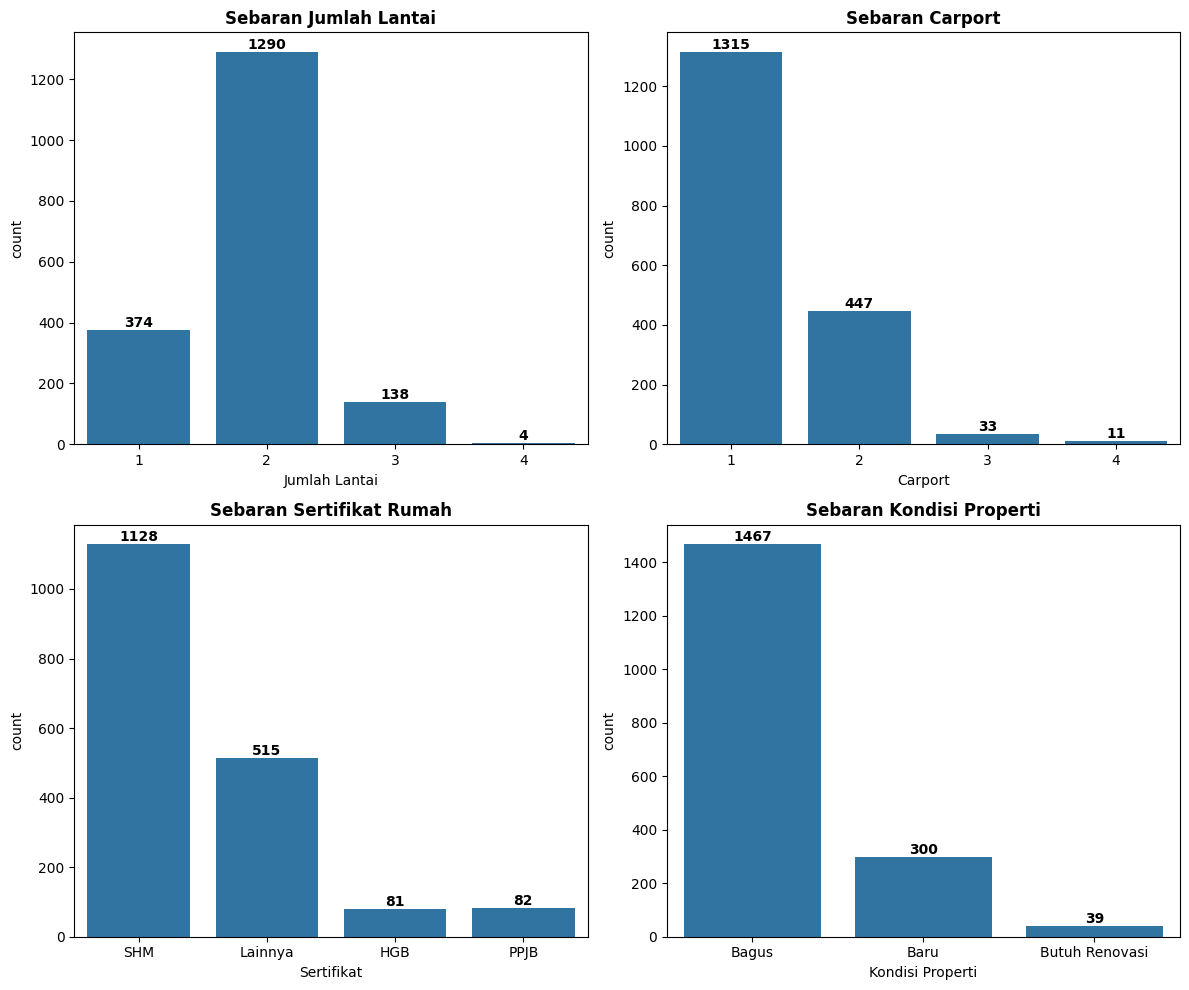

In [9]:
# Visualisasi beberapa kolom
# Membuat figure dengan 2 baris, 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List kolom dan judul
columns = ['Jumlah Lantai', 'Carport', 'Sertifikat', 'Kondisi Properti']
titles = ['Sebaran Jumlah Lantai', 'Sebaran Carport', 'Sebaran Sertifikat Rumah', 'Sebaran Kondisi Properti']

# Loop untuk membuat countplot dan menambahkan data label
for i, ax in enumerate(axes.flat):
    sns.countplot(x=df_kabupaten[columns[i]], ax=ax)
    ax.set_title(titles[i], weight='bold')

    # Menambahkan label di atas batang
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()


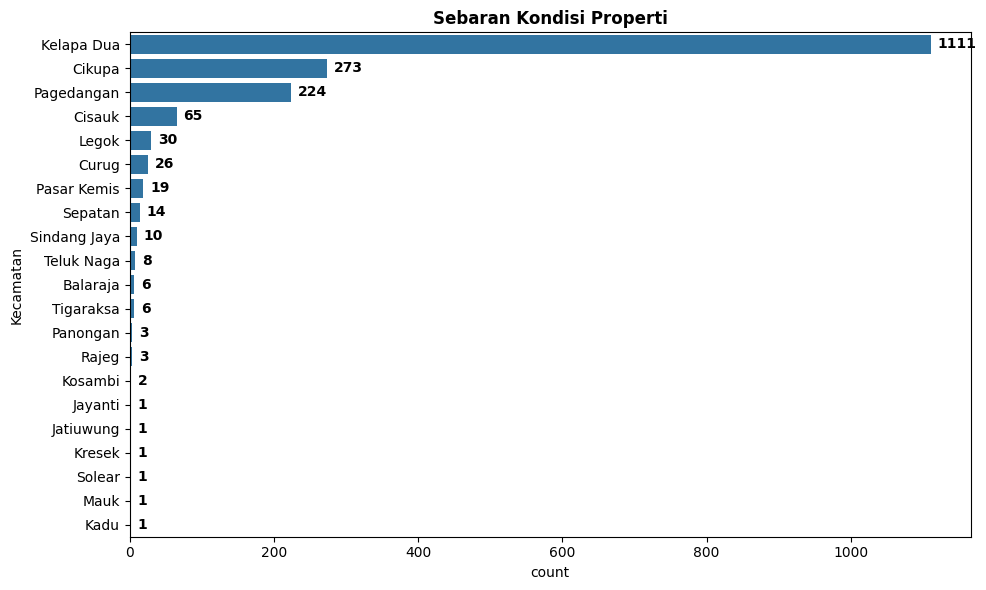

In [10]:
# Lihat sebaran kecamatan
# Membuat figure
plt.figure(figsize=(10, 6))

# Membuat countplot dengan urutan berdasarkan jumlah data
ax = sns.countplot(y=df_kabupaten['Kecamatan'], order=df_kabupaten['Kecamatan'].value_counts().index)

# Menambahkan judul
plt.title("Sebaran Kondisi Properti", weight='bold')

# Menambahkan label pada setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',  # Nilai jumlah properti
                (p.get_width(), p.get_y() + p.get_height() / 2),  # Posisi teks
                ha='left', va='center', fontsize=10, fontweight='bold', xytext=(5, 0), textcoords='offset points')

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()

<Axes: xlabel='Harga', ylabel='Count'>

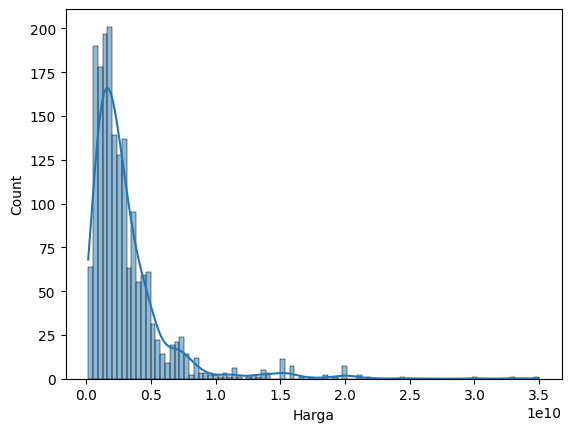

In [11]:
# Cek sebaran harga rumah
sns.histplot(df_kabupaten['Harga'], kde=True)

In [12]:
# Lihat skewness
print(np.round(df_kabupaten['Harga'].skew(), 2))

3.76


Kalau dilihat, datanya memiliki skewness 3.76 sehingga perlu dilakukan normalisasi dengan log transfromation.

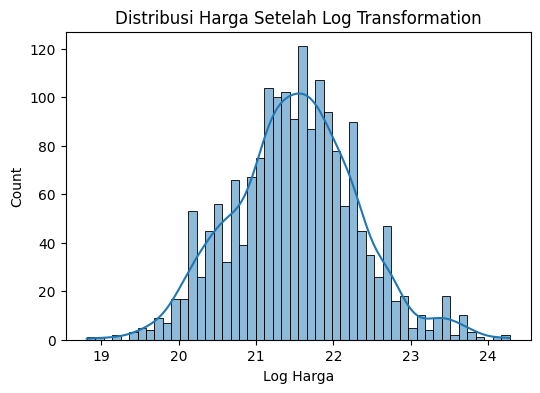

In [13]:
# Melakukan log transformation pada kolom 'harga'
df_kabupaten['Harga Norm'] = np.log1p(df_kabupaten['Harga'])

# Menampilkan distribusi harga setelah transformasi
plt.figure(figsize=(6,4))
sns.histplot(df_kabupaten['Harga Norm'], bins=50, kde=True)
plt.xlabel("Log Harga")
plt.ylabel("Count")
plt.title("Distribusi Harga Setelah Log Transformation")
plt.show()

Distribusinya sudah 'normal'

### Preprocessing

In [14]:
# Encoding
# Label encoding untuk 'Sertifikat'
le_sertifikat = LabelEncoder()
df_kabupaten['Sertifikat'] = le_sertifikat.fit_transform(df_kabupaten['Sertifikat'])

# Label encoding untuk 'Kondisi Properti'
le_kondisi = LabelEncoder()
df_kabupaten['Kondisi Properti'] = le_kondisi.fit_transform(df_kabupaten['Kondisi Properti'])

# Encoding Kecamatan
df_kabupaten = pd.get_dummies(df_kabupaten, columns=['Kecamatan'], prefix='kec')

# Lihat hasilnya
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 6 to 4990
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Harga                 1806 non-null   int64  
 1   Kamar Tidur           1806 non-null   Int64  
 2   Kamar Mandi           1806 non-null   Int64  
 3   Luas Tanah            1806 non-null   Int64  
 4   Luas Bangunan         1806 non-null   Int64  
 5   Sertifikat            1806 non-null   int64  
 6   Daya Listrik          1806 non-null   Int64  
 7   Jumlah Lantai         1806 non-null   Int64  
 8   Kondisi Properti      1806 non-null   int64  
 9   Carport               1806 non-null   Int64  
 10  Kamar Tidur Pembantu  1806 non-null   Int64  
 11  Kamar Mandi Pembantu  1806 non-null   Int64  
 12  Harga Norm            1806 non-null   float64
 13  kec_Balaraja          1806 non-null   bool   
 14  kec_Cikupa            1806 non-null   bool   
 15  kec_Cisauk            1806

In [15]:
# Lihat 5 data teratas setelah encoding
df_kabupaten.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,...,kec_Mauk,kec_Pagedangan,kec_Panongan,kec_Pasar Kemis,kec_Rajeg,kec_Sepatan,kec_Sindang Jaya,kec_Solear,kec_Teluk Naga,kec_Tigaraksa
6,1000000000,2,1,90,55,3,2200,1,0,1,...,False,False,False,False,False,False,False,False,False,False
8,1000000000,2,1,90,55,3,2200,1,0,1,...,False,False,False,False,False,False,False,False,False,False
14,1000000000,3,2,644,135,3,1300,1,0,1,...,False,False,False,False,False,False,False,False,False,False
15,1000000000,3,2,66,79,3,3500,2,0,1,...,False,False,False,True,False,False,False,False,False,False
21,1000000000,3,3,120,166,3,1300,2,1,2,...,False,False,False,False,False,False,False,False,False,False


Feature Selection

<Axes: >

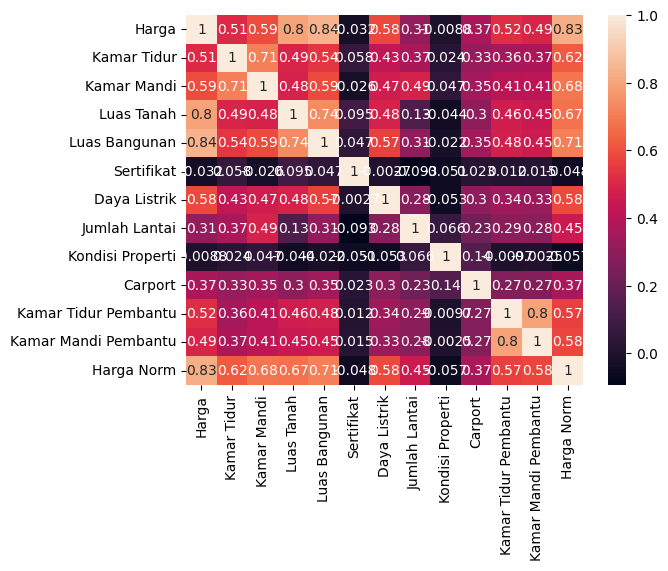

In [16]:
# Lihat korelasi antar variabel numerik (Pearson)
sns.heatmap(df_kabupaten.select_dtypes(include=['number']).corr(), annot=True)

In [ ]:
# Pisahkan fitur dan target
X = df_kabupaten.drop(columns=['Harga', 'Harga Norm'], axis=1)
y = df_kabupaten['Harga Norm']

# Split dataset menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling & Evaluation
---
Base Model Linear Regression

In [ ]:
# Inisialisasi model Linear Regression
lr = LinearRegression()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan metrik
r2_scores = []
rmse_scores = []
mape_scores = []

# Melakukan K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Melatih model
    lr.fit(X_train_fold, y_train_fold)
    
    # Melakukan prediksi
    y_val_pred = lr.predict(X_val_fold)
    
    # Menghitung metrik
    r2 = r2_score(y_val_fold, y_val_pred)
    rmse = root_mean_squared_error(y_val_fold, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    
    # Menyimpan metrik
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print("Cross validation score on base Multiple Linear Regression:\n")
print(f"Mean CV R²: {mean_r2}")
print(f"Mean CV RMSE: {mean_rmse}")
print(f"Mean CV MAPE: {mean_mape}")

# Melatih model pada seluruh data pelatihan
lr.fit(X_train.iloc, y_train)

# Melakukan prediksi pada data latih
y_pred_lr_train = lr.predict(X_train.iloc)

# Menghitung metrik pada data uji
train_r2_base_lr = r2_score(y_test, y_pred_lr_train)
train_rmse_base_lr = root_mean_squared_error(y_test, y_pred_lr_train)
train_mape_base_lr = mean_absolute_percentage_error(y_test, y_pred_lr_train)

# Melakukan prediksi pada data uji
y_pred_lr = lr.predict(X_test.iloc)

# Menghitung metrik pada data uji
test_r2_base_lr = r2_score(y_test, y_pred_lr)
test_rmse_base_lr = root_mean_squared_error(y_test, y_pred_lr)
test_mape_base_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("Train vs Test Result:\n")
print(f"Train R²: {train_r2_base_lr}")
print(f"Train RMSE: {train_rmse_base_lr}")
print(f"Train MAPE: {train_mape_base_lr}\n")
print(f"Test R²: {test_r2_base_lr}")
print(f"Test RMSE: {test_rmse_base_lr}")
print(f"Test MAPE: {test_mape_base_lr}")

Mean CV R²: 0.8038647887600809
Mean CV RMSE: 0.3515803984797033
Mean CV MAPE: 0.011827584101483091

Test R²: 0.8484420597589465
Test RMSE: 0.32380213843153094
Test MAPE: 0.011431589777171


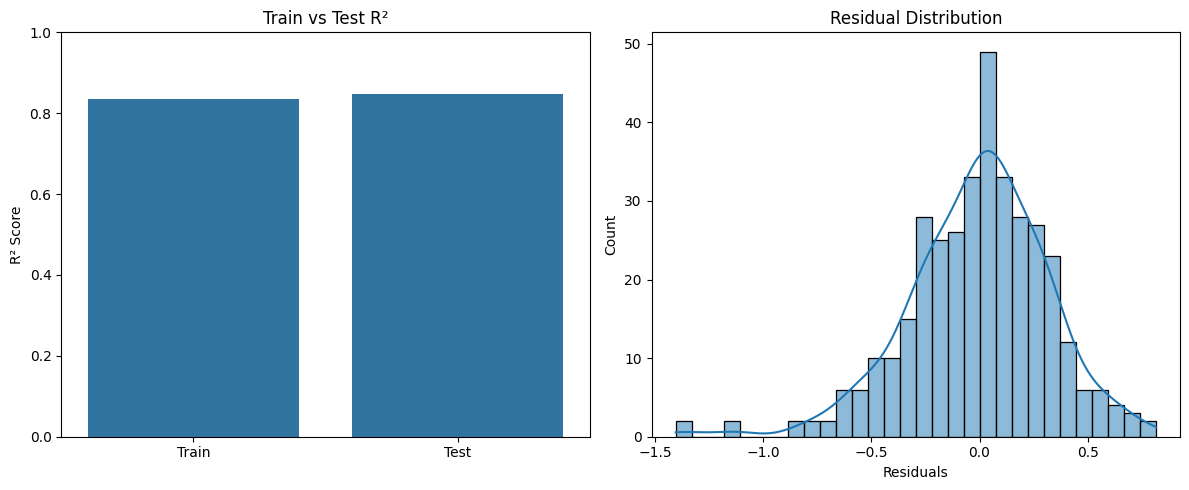

In [ ]:
# Hitung R² pada training data
train_r2 = r2_score(y_train, lr.predict(X_train))

# Buat figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Train vs Test R² Comparison
sns.barplot(x=["Train", "Test"], y=[train_r2, test_r2_base_lr], ax=axes[0])
axes[0].set_title("Train vs Test R²")
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("R² Score")

# 2️⃣ Residual Plot
residuals = y_test - y_pred_lr
sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

Base Model Random Forest

In [ ]:
# Inisialisasi model Linear Regression
rfr = RandomForestRegressor()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan metrik
r2_scores = []
rmse_scores = []
mape_scores = []

# Melakukan K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Melatih model
    rfr.fit(X_train_fold, y_train_fold)
    
    # Melakukan prediksi
    y_val_pred = rfr.predict(X_val_fold)
    
    # Menghitung metrik
    r2 = r2_score(y_val_fold, y_val_pred)
    rmse = root_mean_squared_error(y_val_fold, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    
    # Menyimpan metrik
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print(f"Mean CV R²: {mean_r2}")
print(f"Mean CV RMSE: {mean_rmse}")
print(f"Mean CV MAPE: {mean_mape}")

# Melatih model pada seluruh data pelatihan
rfr.fit(X_train, y_train)

# Melakukan prediksi pada data uji
y_pred_rf = rfr.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_rfr = r2_score(y_test, y_pred_rf)
test_rmse_base_rfr = root_mean_squared_error(y_test, y_pred_rf)
test_mape_base_rfr = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"\nTest R²: {test_r2_base_rfr}")
print(f"Test RMSE: {test_rmse_base_rfr}")
print(f"Test MAPE: {test_mape_base_rfr}")

Mean CV R²: 0.9022883815243107
Mean CV RMSE: 0.2492546705348541
Mean CV MAPE: 0.007936388205099922

Test R²: 0.9177867113127917
Test RMSE: 0.23848516889985727
Test MAPE: 0.0075973741018622865


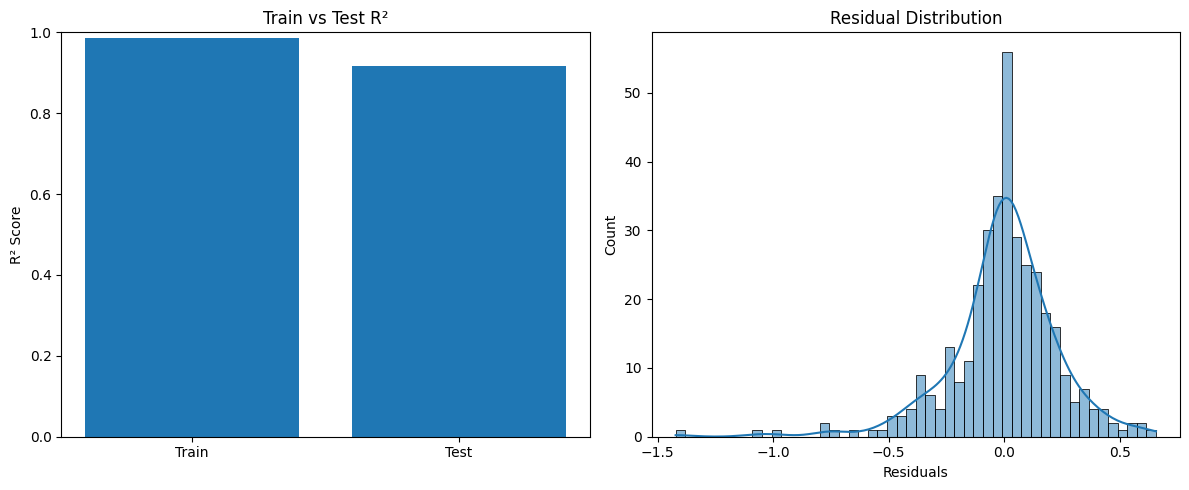

In [ ]:
# Mendapatkan skor R² untuk data train
train_r2_rf = r2_score(y_train, rfr.predict(X_train))

# Plot Train vs Test R²
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["Train", "Test"], [train_r2_rf, test_r2_base_rfr])
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.title("Train vs Test R²")

# Menghitung residuals
y_residuals_rf = y_test - y_pred_rf

# Plot Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_residuals_rf, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

Base Model XGBoost

In [ ]:
# Inisialisasi model Linear Regression
xgb = XGBRegressor()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan metrik
r2_scores = []
rmse_scores = []
mape_scores = []

# Melakukan K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Melatih model
    xgb.fit(X_train_fold, y_train_fold)
    
    # Melakukan prediksi
    y_val_pred = xgb.predict(X_val_fold)
    
    # Menghitung metrik
    r2 = r2_score(y_val_fold, y_val_pred)
    rmse = root_mean_squared_error(y_val_fold, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    
    # Menyimpan metrik
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print(f"Mean CV R²: {mean_r2}")
print(f"Mean CV RMSE: {mean_rmse}")
print(f"Mean CV MAPE: {mean_mape}")

# Melatih model pada seluruh data pelatihan
xgb.fit(X_train, y_train)

# Melakukan prediksi pada data uji
y_pred_xgb = xgb.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_xgb = r2_score(y_test, y_pred_xgb)
test_rmse_base_xgb = root_mean_squared_error(y_test, y_pred_xgb)
test_mape_base_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"\nTest R²: {test_r2_base_xgb}")
print(f"Test RMSE: {test_rmse_base_xgb}")
print(f"Test MAPE: {test_mape_base_xgb}")

Mean CV R²: 0.909697024238288
Mean CV RMSE: 0.24001870104902565
Mean CV MAPE: 0.00782444019682238

Test R²: 0.9258947637342777
Test RMSE: 0.22642001431876232
Test MAPE: 0.007250571460074984


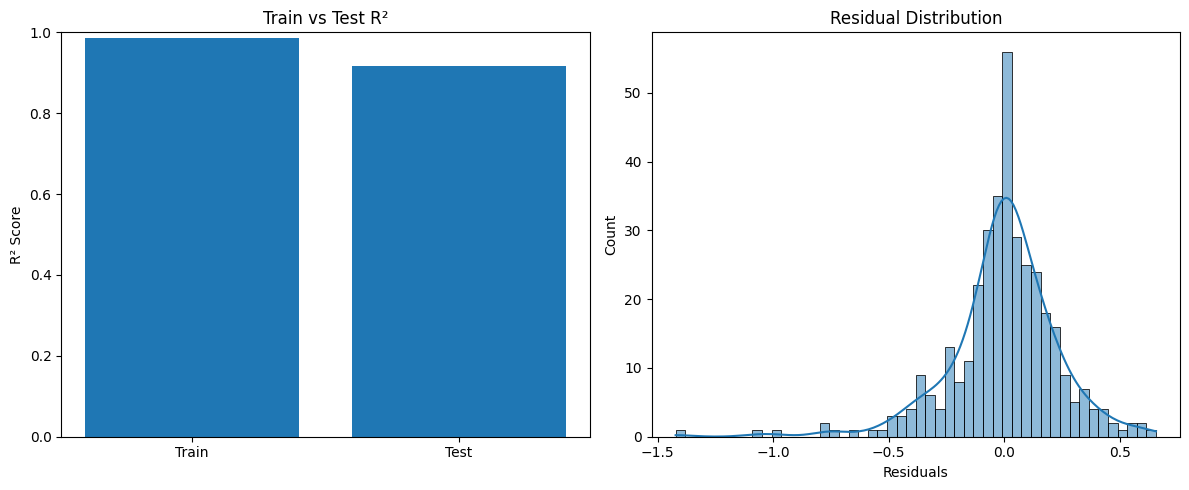

In [ ]:
# Mendapatkan skor R² untuk data train
train_r2_xgb = r2_score(y_train, xgb.predict(X_train))

# Plot Train vs Test R²
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["Train", "Test"], [train_r2_rf, test_r2_base_rfr])
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.title("Train vs Test R²")

# Menghitung residuals
y_residuals_xgb = y_test - y_pred_xgb

# Plot Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_residuals_rf, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

Random Forest dengan Optuna

In [ ]:
# Fungsi Optuna untuk tuning Random Forest
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 4, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 10),
        "max_features": trial.suggest_float("max_features", 0.3, 0.8),
        "bootstrap": True 
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2_opt = r2_score(y_test, y_pred)
    return r2_opt

# Jalankan Optuna
study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective, n_trials=100)

# Print hasil tuning terbaik
print("Best hyperparameters for Random Forest:", study_rf.best_params)

# Latih model final dengan hyperparameter terbaik
best_params_rf = study_rf.best_params
final_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)

# Evaluasi model di data uji
y_pred_opt_rf = final_rf.predict(X_test)
test_rmse_opt_rfr = root_mean_squared_error(y_test, y_pred_opt_rf)
test_r2_opt_rfr = r2_score(y_test, y_pred_opt_rf)
test_mape_opt_rfr = mean_absolute_percentage_error(y_test, y_pred_opt_rf)

print("\nFinal Random Forest Performance:")
print(f"Test R²: {test_r2_opt_rfr}")
print(f"Test RMSE: {test_rmse_opt_rfr}")
print(f"Test MAPE: {test_mape_opt_rfr}")

[I 2025-02-22 13:11:13,968] A new study created in memory with name: no-name-ec7b4083-6984-4c53-9656-8e466231e9bd
[I 2025-02-22 13:11:14,262] Trial 0 finished with value: 0.32838746685832154 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.793122570402236}. Best is trial 0 with value: 0.32838746685832154.
[I 2025-02-22 13:11:14,672] Trial 1 finished with value: 0.2697166904378099 and parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.7384673875785615}. Best is trial 1 with value: 0.2697166904378099.
[I 2025-02-22 13:11:15,012] Trial 2 finished with value: 0.2730605542937597 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 0.4948137722835048}. Best is trial 1 with value: 0.2697166904378099.
[I 2025-02-22 13:11:15,561] Trial 3 finished with value: 0.29264633994116196 and parameters: {'n_e

Best hyperparameters for Random Forest: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.44195183546248484}

Final Random Forest Performance:
Test R²: 0.9178609330737961
Test RMSE: 0.2383774929611916
Test MAPE: 0.008005942256136786


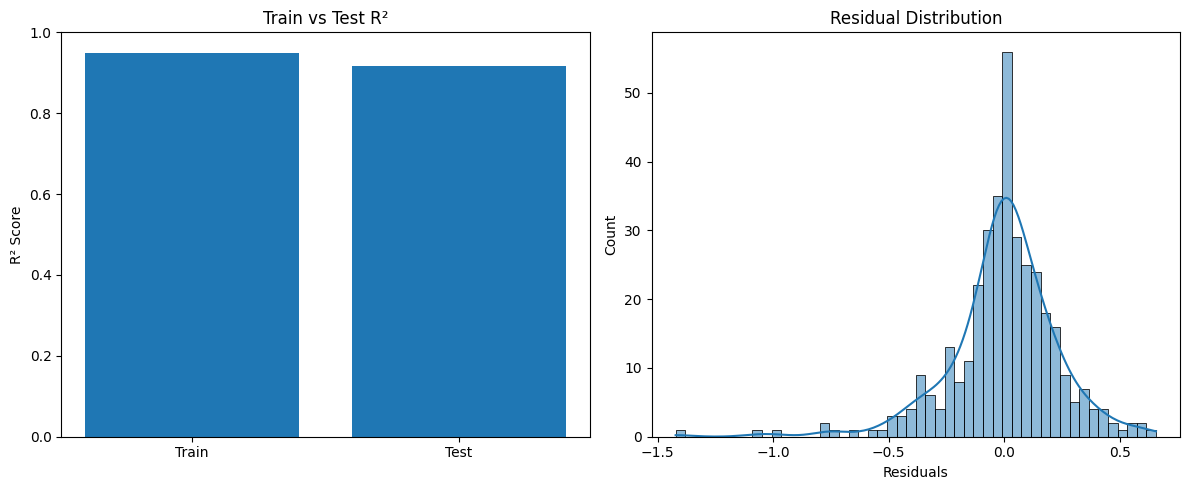

In [33]:
# Mendapatkan skor R² untuk data train
train_r2_opt_rfr = r2_score(y_train, final_rf.predict(X_train))

# Plot Train vs Test R²
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["Train", "Test"], [train_r2_opt_rfr, test_r2_opt_rfr])
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.title("Train vs Test R²")

# Menghitung residuals
y_residuals_rfr = y_test - train_r2_opt_rfr

# Plot Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_residuals_rf, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

XGBoost dengan Optuna

In [41]:
# Definisikan fungsi tujuan untuk Optuna
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, step=200),  
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),  
    "max_depth": trial.suggest_int("max_depth", 4, 12),  
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  
    "subsample": trial.suggest_float("subsample", 0.7, 1.0),  
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),  
    "gamma": trial.suggest_float("gamma", 0, 5),  
    "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),  
    "reg_lambda": trial.suggest_float("reg_lambda", 0, 5)   
    }

    # Inisialisasi model XGBoost
    model = XGBRegressor(**params)

    # Inisialisasi KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Menyimpan metrik
    r2_scores = []
    mape_scores = []
    
    # Melakukan K-Fold Cross-Validation
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Melatih model
        model.fit(X_train_fold, y_train_fold)
        
        # Melakukan prediksi
        y_val_pred = model.predict(X_val_fold)
        
        # Menghitung R²
        r2 = r2_score(y_val_fold, y_val_pred)
        r2_scores.append(r2)
        
        # Menghitung MAPE
        mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
        mape_scores.append(mape)

    # Mengembalikan rata-rata R² sebagai nilai yang akan dioptimalkan
    return np.mean(r2_scores)

# Tuning hyperparameter dengan Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Menampilkan hyperparameter terbaik
print("Best hyperparameters: ", study.best_params)

# Melatih model dengan hyperparameter terbaik
best_params = study.best_params
best_model_xgb = XGBRegressor(**best_params)
best_model_xgb.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_opt_xgb_train = best_model_xgb.predict(X_train)

# Menghitung metrik pada data uji
train_r2_opt_xgb = r2_score(y_train, y_pred_opt_xgb_train)
train_rmse_opt_xgb = root_mean_squared_error(y_train, y_pred_opt_xgb_train)
train_mape_opt_xgb = mean_absolute_percentage_error(y_train, y_pred_opt_xgb_train)

# Melakukan prediksi pada data uji
y_pred_opt_xgb = best_model_xgb.predict(X_test)

# Menghitung metrik pada data uji
test_r2_opt_xgb = r2_score(y_test, y_pred_opt_xgb)
test_rmse_opt_xgb = root_mean_squared_error(y_test, y_pred_opt_xgb)
test_mape_opt_xgb = mean_absolute_percentage_error(y_test, y_pred_opt_xgb)

print("\nXGBoost Optuna Result:")
print(f"Train R²: {train_r2_opt_xgb}")
print(f"Train RMSE: {train_rmse_opt_xgb}")
print(f"Train MAPE: {train_mape_opt_xgb}\n")
print(f"Test R²: {test_r2_opt_xgb}")
print(f"Test RMSE: {test_rmse_opt_xgb}")
print(f"Test MAPE: {test_mape_opt_xgb}")

[I 2025-02-22 13:49:05,600] A new study created in memory with name: no-name-b2db76c4-c7c3-4e4e-92e0-c62d338dc445
[I 2025-02-22 13:49:11,359] Trial 0 finished with value: 0.8701932615964821 and parameters: {'n_estimators': 5000, 'learning_rate': 0.04047342087873954, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.9580933715055115, 'colsample_bytree': 0.9620408572053265, 'gamma': 3.496221272508997, 'reg_alpha': 0.6400553619921606, 'reg_lambda': 2.156587952896352}. Best is trial 0 with value: 0.8701932615964821.
[I 2025-02-22 13:49:16,326] Trial 1 finished with value: 0.8807005551522928 and parameters: {'n_estimators': 4200, 'learning_rate': 0.05963927020970619, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9437934953000939, 'colsample_bytree': 0.7271461149030821, 'gamma': 1.4484870087044366, 'reg_alpha': 3.1106118023199976, 'reg_lambda': 0.531592824657452}. Best is trial 1 with value: 0.8807005551522928.
[I 2025-02-22 13:49:18,889] Trial 2 finished with value: 0.871203904

Best hyperparameters:  {'n_estimators': 2000, 'learning_rate': 0.012070800294603475, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7255702438553688, 'colsample_bytree': 0.7799187220217119, 'gamma': 0.01039345097530367, 'reg_alpha': 0.19640171293935316, 'reg_lambda': 2.509216287286011}

XGBoost Optuna Result:
Train R²: 0.9799970798316917
Train RMSE: 0.1131799535220846
Train MAPE: 0.003914131542702799

Test R²: 0.9286638144983018
Test RMSE: 0.22214948301077578
Test MAPE: 0.007134180293217088


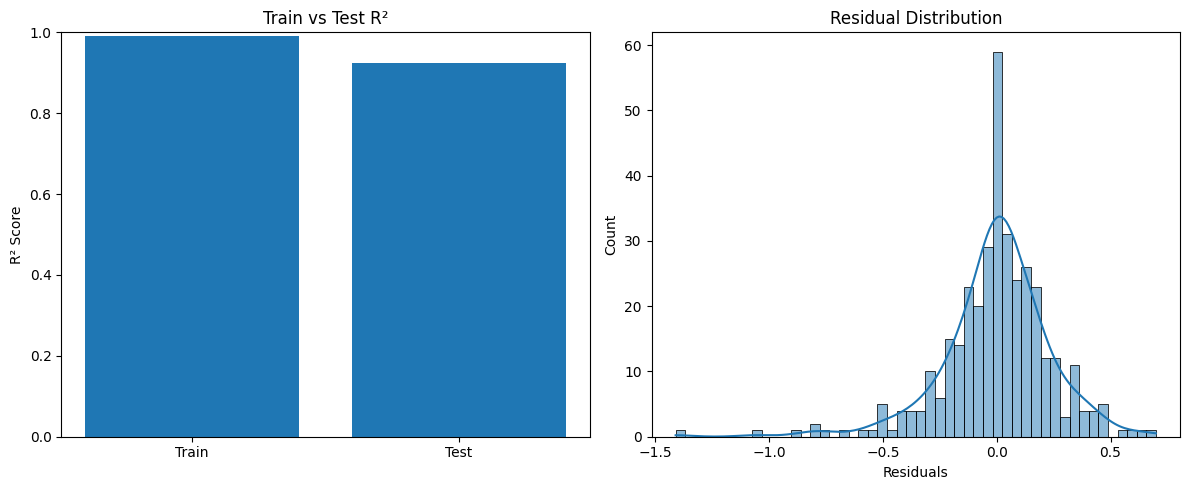

In [ ]:
# Mendapatkan skor R² untuk data train
train_r2_opt_xgb = r2_score(y_train, best_model_xgb.predict(X_train))

# Plot Train vs Test R²
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["Train", "Test"], [train_r2_opt_xgb, test_r2_opt_xgb])
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.title("Train vs Test R²")

# Menghitung residuals
y_residuals_rfr = y_test - train_r2_opt_xgb

# Plot Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_residuals_rf, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

Evaluasi Keseluruhan

In [ ]:
df_eval = pd.DataFrame(data={
    'Model' : ['Multiple Linear Regression', 'Base Random Forest', 'Base XGBoost', 'Optuna Random Forest', 'Optuna XGBoost'],
    'R-squared' : [test_r2_base_lr, test_r2_base_rfr, test_r2_base_xgb, test_r2_opt_rfr, test_r2_opt_xgb],
    'RMSE' : [test_rmse_base_lr, test_rmse_base_rfr, test_rmse_base_xgb, test_rmse_opt_rfr, test_rmse_opt_xgb],
    'MAPE' : [test_mape_base_lr, test_mape_base_rfr, test_mape_base_xgb, test_mape_opt_rfr, test_mape_opt_xgb]
})

print("Perbandingan akurasi di test set:\n")
df_eval

Perbandingan akurasi di test set:



,Model,R-squared,RMSE,MAPE
0,Multiple Linear Regression,0.851895,0.320093,0.011398
1,Base Random Forest,0.915937,0.241152,0.007779
2,Base XGBoost,0.925895,0.226420,0.007251
3,Optuna Random Forest,0.921145,0.233563,0.007468
4,Optuna XGBoost,0.924885,0.227958,0.007161
